##Feature Engineering

- Main preprocessing operations

-Data cleansing

-Feature tuning

-transformation

-feature extraction

-feature construction


* Feature Engineering techniques

-**Scaling**:

prescribed range

+Grayscale image instensity scale is [0,55] rescaled to [-1,1]

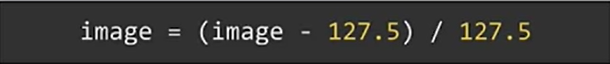





benefits:

+NN converge faster

+for each fetaure, the model learns the right weights

-**Normalization**

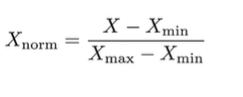

+Good if your data is not Gaussian

- **Standardization**

-Z-score relates the number of standard deviations away from the mean.


- **Bucketizing/Binning**

- **Dimensionality reduction in embeddings**

-PCA

-t_SNE(t-Distributed stochastic neighbor embedding)

-UMAP(Uniform manifold approximation and projection)


- **feature crossing**

combines multiple features together into a new feature.





* Feature transformation at Scale


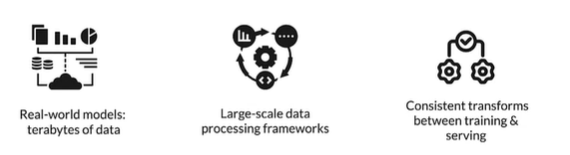


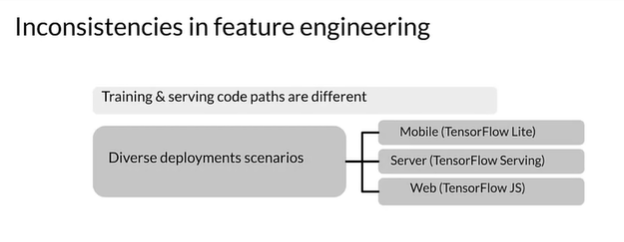

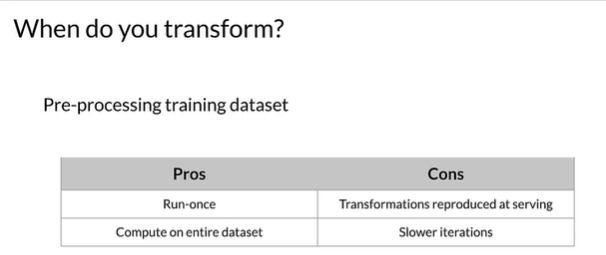

* **Tensorflow transform**

tf.Transform

**With Tensorflow Transform, you can preprocess data using the same code for both training a model and serving inferences in production. It provides several utility functions for common preprocessing tasks including creating features that require a full pass over the training dataset. The outputs are the transformed features and a TensorFlow graph which you can use for both training and serving. Using the same graph for both training and serving can prevent feature skew, since the same transformations are applied in both stages.**

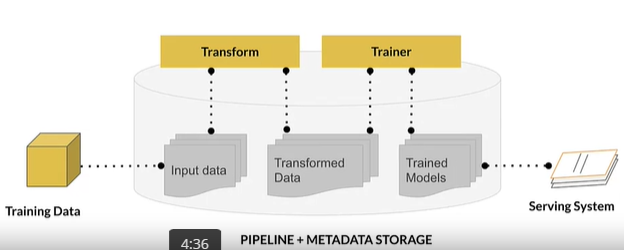

* Tensorflow extended

data ==> splitted using **Example Gen** (Train,test) ==> calulate stats **Statistics Gen** (mean,std,max,min) ==> **Schema gen** infer the schema  ==> **Example Validator** used between schema and stat Gen in order to valid the schema ==> **transform** is where the feature engineering happen ==> **trainer** ==> **Evaluator** ==> **Pusher**


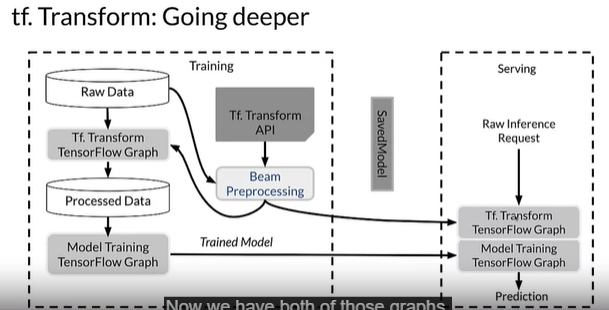

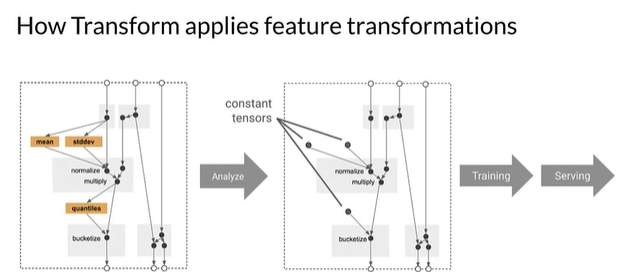


Analyze ==> to process the full-pass data process like calculating the max or the min over the whole dataset

## Hello World exmaple with tf.Transform

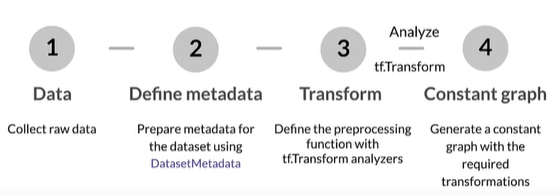

The main steps to preprocess input data:

1.Collect raw data

2.Define metadata

3.Create a preprocessing function

4.Generate a constant graph with the required transformations

In [ ]:
!pip install tensorflow_transform

In [ ]:
!pip install dataset_schema


ERROR: Could not find a version that satisfies the requirement dataset_schema (from versions: none)
ERROR: No matching distribution found for dataset_schema


In [ ]:
#prepare metdata = their types and relationships

import tensorflow as tf
import tensorflow_transform as tft

#tensorflow_transform.beam provides functionality to execute preprocessing pipelines using Apache Beam, which is a powerful framework for parallel and distributed data processing.
import tensorflow_transform.beam as tft_beam


from tensorflow_transform.tf_metadata import dataset_metadata
from tensorflow_transform.tf_metadata import schema_utils

import pprint
import tempfile

print(f'TensorFlow version: {tf.__version__}')
print(f'TFX Transform version: {tft.__version__}')


TensorFlow version: 2.13.0
TFX Transform version: 1.14.0


* Collect raw data

In [ ]:
Dummy_data=[
    {'x':1,'y':1,'s':'hello'},
    {'x':2,'y':2,'s':'world'},
    {'x':3,'y':3,'s':'hello'}
]

* Define the metadata

The transform function later expects the metadata to be packed in a DatasetMetadata object.

The constructor for the DatasetMetadata class expects a Schema protocol buffer data type. You can use the schema_from_feature_spec() method to generate that from a dictionary.

To build the said dictionary, you will use the keys/column names of raw_data and assign a FeatureSpecType as values. This allows you to specify if the input is fixed or variable length (using tf.io classes), as well as to define the shape and data type.


In [ ]:
#let's define our schema as a DatasetMetadata object

raw_data_metadata= dataset_metadata.DatasetMetadata(
    schema_utils.schema_from_feature_spec(
        {
            #now we will define the dictionnary that map keys to feature's type
            'y': tf.io.FixedLenFeature([],tf.float32),
            #[] means that the feature is a scalar value that has no specific shape or dimension
            'x': tf.io.FixedLenFeature([],tf.float32),
            's': tf.io.FixedLenFeature([],tf.string),

        }
    )


)

In [ ]:
#Preview the data
print(raw_data_metadata._schema)

feature {
  name: "s"
  type: BYTES
  presence {
    min_fraction: 1.0
  }
  shape {
  }
}
feature {
  name: "x"
  type: FLOAT
  presence {
    min_fraction: 1.0
  }
  shape {
  }
}
feature {
  name: "y"
  type: FLOAT
  presence {
    min_fraction: 1.0
  }
  shape {
  }
}



* create a preprocessing function

A preprocessing function is where the transformation of the dataset really happens.

There are two main groups of API calls that typically form the heart of a preprocessing function:

* **TensorFlow Ops**: Any function that accepts and returns tensors. These add TensorFlow operations to the graph that transforms raw data into transformed data one feature vector at a time. These will run for every example, during both training and serving.

* **TensorFlow Transform Analyzers**: Any of the analyzers provided by tf.Transform. Analyzers also accept and return tensors, but unlike TensorFlow ops they only run once during training, and typically make a full pass over the entire training dataset. They create tensor constants, which are added to your graph. For example, tft.min computes the minimum of a tensor over the training dataset.

In [ ]:
def preprocessing_fn(inputs):
    """Preprocess input columns into transformed columns."""

    # extract the columns and assign to local variables
    x = inputs['x']
    y = inputs['y']
    s = inputs['s']

    # data transformations using tft functions
    x_centered = x - tft.mean(x)
    y_normalized = tft.scale_to_0_1(y)
    s_integerized = tft.compute_and_apply_vocabulary(s)
    x_centered_times_y_normalized = (x_centered * y_normalized)

    # return the transformed data
    return {
        'x_centered': x_centered,
        'y_normalized': y_normalized,
        's_integerized': s_integerized,
        'x_centered_times_y_normalized': x_centered_times_y_normalized,
    }

* Generate a constant graph with the required transformations

Tensorflow Transform also uses Apache Beam for deployment scalability and flexibility. As you'll see below, Beam uses the pipe (|) operator to stack the different stages of the pipeline.



In [ ]:
#ignore the warnings

tf.get_logger().setLevel('ERROR')

#a temporary directory for intermediate data storage and processing

with tft_beam.Context(temp_dir=tempfile.mkdtemp()):

  #define the pipeline using Apache Beam

     transformed_dataset, transform_fn = (

        # analyze and transform the dataset using the preprocessing function
        (Dummy_data, raw_data_metadata) | tft_beam.AnalyzeAndTransformDataset(
            preprocessing_fn)
    )





  #unpack the transformed data

transformed_data, transformed_metada=transformed_dataset


# print the results
print('\nRaw data:\n{}\n'.format(pprint.pformat(Dummy_data)))
print('Transformed data:\n{}'.format(pprint.pformat(transformed_data)))



Raw data:
[{'s': 'hello', 'x': 1, 'y': 1},
 {'s': 'world', 'x': 2, 'y': 2},
 {'s': 'hello', 'x': 3, 'y': 3}]

Transformed data:
[{'s_integerized': 0,
  'x_centered': -1.0,
  'x_centered_times_y_normalized': -0.0,
  'y_normalized': 0.0},
 {'s_integerized': 1,
  'x_centered': 0.0,
  'x_centered_times_y_normalized': 0.0,
  'y_normalized': 0.5},
 {'s_integerized': 0,
  'x_centered': 1.0,
  'x_centered_times_y_normalized': 1.0,
  'y_normalized': 1.0}]


# Feature Selection

* Feature spaces

-N dimensional space defined by your N features(without including the target label)

 We have to ensure feature space coverage.(continuous monitoring)



* Feature selection
We simply remove the features that don't influence the outcome.

So we are reducing the feature space size ==> reduce storage ==> minimize training and serving costs.

--UNSUPERVISED FEATURE SELECTION--

Features-target relationship is not considered.

Removes redundant features(features that are correlated)

--SUPERVISED FEATURE SELECTION--

Use features-target relationship

and selects features that contribute more



* Filter methods

-Remove redundant:
Popular filter methods:

      * Pearson Correlation

      * Kendall Tau Rank Correlation

      * Spearman's Rank correlation

      * Mutual Information

      * F-test

      * Chi-squared

-Univariate feature selection in SKLearn

      * SeelectKBest

      * SelectPercentile

      * GenericUnivariateSelect

      stat test

      * Regression:

      f_regression,mutual_info_regression

      * Classification

      chi2, f_classif,mutual_info_classif





* Wrapper methods
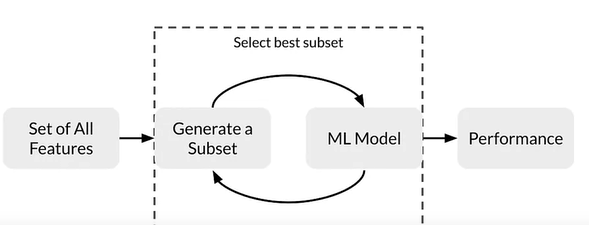

    * Forward Selection

        Algorithm:

        1. Starts with 1 feature

        2. Evaluate model performance

        3. Add next feature

        4. repeat until no improvement

    * Backward selection

        Algorithm:

        1. Starts with all features

        2. Evaluate model performance

        3. Remove next features( that gives worst performance)

        4. Repeat until there is no improvement

    * RFE Recursive feature elimination


    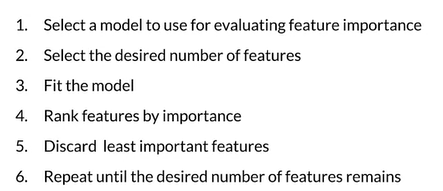




* Embedded Methods

    * feature importance



---------------------

# HOW TO BUILD A PIPELINE USING TENSORFLOW EXTENDED

1. Creation of the **interactive context**

Interactive context is a class provided by TFX for interactive Exec and experimentation of TFX components and pipelines

It is for testing and debugging purpose

----
 * context = InteractiveContext(pipeline_root=_pipeline_root)
-----

#### * Runining TFX components

1. **ExampleGen:**

Our Pipeline starts with this componenet that is responsible for:

* splitting the data into training and evaluation sets(2/3 train, 1/3 test)

* converting each data row into tf.train.Example format.

* compressing and saving the data collection under the _pipeline_root directory for other components to access. These examples are stored in TFRecord format. This optimizes read and write operations within Tensorflow especially if you have a large collection of data.



--
    # Instantiate ExampleGen with the input CSV dataset
    example_gen =tfx.components.CsvExampleGen(input_base=_data_root)

    # Run the component using the InteractiveContext instance
    context.run(example_gen)
--



2. **Statistics Gen**

* Uses TensorFlow Data validation library

* It takes as input the dataset ingested using CsvExampleGen

---
      # Instantiate StatisticsGen with the ExampleGen ingested dataset
      statistics_gen = tfx.components.StatisticsGen(examples=example_gen.outputs['examples'])
    

      # Run the component
      context.run(statistics_gen
---

3.**Schema Gen**

* Uses TFDV to generate our schema

----
    # Instantiate SchemaGen with the output statistics from the StatisticsGen
    schema_gen = tfx.components.SchemaGen(statistics=statistics_gen.outputs['statistics'])
        
        

    # Run the component
    context.run(schema_gen)
----

-----
    # Visualize the output
    context.show(schema_gen.outputs['schema'])
----

4. **Example validator**

* its main purpose is to detect anomalies based on the schema generated by SchemaGen component

* By default it compares the stats from the evaluation split to the schema from the training split


---
    # Instantiate ExampleValidator with the statistics and schema from the previous steps
    example_validator = tfx.components.ExampleValidator(statistics=statistics_gen.outputs['statistics'],
                                                        schema=schema_gen.outputs['schema'])
        
        

    # Run the component
    context.run(example_validator)
---



5. **Transform**

